In [2]:
import os 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [3]:
data_dir = 'chest_xray'

In [27]:
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')

In [28]:
def load_images(direct):
    image_paths = []
    labels = []
    classes = ['NORMAL','PNEUMONIA']
    class_to_idx = {'NORMAL':0,'PNEUMONIA':1}
    for class_name in classes:
        class_dir = os.path.join(direct,class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpeg','.jpg','.png')):
                img_path = os.path.join(class_dir,img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
    return image_paths, labels

In [29]:
train_paths,train_labels = load_images(train_dir)
test_paths,test_labels = load_images(test_dir)

In [47]:
from sklearn.model_selection import train_test_split
train_paths_new,val_paths,train_labels_new,val_labels = train_test_split(train_paths,train_labels,test_size=0.2,random_state=42,stratify=train_labels)

In [50]:
class_weights = compute_class_weight('balanced',classes=np.unique(train_labels_new),y=train_labels_new)

In [51]:
print(f"Class weights calculated:")
print(f"NORMAL:{class_weights[0]:.3f}")
print(f"PNEUMONIA:{class_weights[1]:.3f}")

Class weights calculated:
NORMAL:1.939
PNEUMONIA:0.674


In [52]:
class_weights_tensor = torch.FloatTensor(class_weights)

In [53]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],std=[0.229])])

test_val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],std=[0.229])])

In [54]:
class ImageDataset(Dataset):
    def __init__(self,image_paths,labels,transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image,label

In [55]:
train_dataset = ImageDataset(train_paths_new,train_labels_new,train_transforms)
val_dataset = ImageDataset(val_paths,val_labels,test_val_transforms)
test_dataset = ImageDataset(test_paths,test_labels,test_val_transforms)

In [56]:
batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [57]:
images,labels = next(iter(train_loader))

In [58]:
print(f"Batch shape: {images.shape}") 
print(f"Labels shape: {labels.shape}")  
print(f"Image dtype: {images.dtype}")   
print(f"Labels dtype: {labels.dtype}")  
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Unique labels: {labels.unique()}")


Batch shape: torch.Size([32, 1, 224, 224])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Labels dtype: torch.int64
Image range: [-2.118, 2.249]
Unique labels: tensor([0, 1])


In [59]:
normal_count = (labels==0).sum().item()
pneumonia_count = (labels==1).sum().item()
print(f"Batch class distribution:")
print(f"NORMAL:{normal_count}")
print(f"PNEUMONIA:{pneumonia_count}")

Batch class distribution:
NORMAL:10
PNEUMONIA:22


In [60]:
class BaselineCNN(nn.Module):
    def __init__(self,num_classes=2):
        super(BaselineCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1 = nn.Linear(128*28*28,128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [61]:
baseline_model  = BaselineCNN()
baseline_model 

BaselineCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [62]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout1 = nn.Dropout2d(0.1)
        
        self.conv2_1 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout2 = nn.Dropout2d(0.2)

        self.conv3_1 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.conv3_3 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bn3_3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout3 = nn.Dropout2d(0.3)

        self.conv4_1 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout4 = nn.Dropout2d(0.4)

        self.conv5_1 = nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout5 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1_1(self.conv1_1(x)))    
        x = F.relu(self.bn1_2(self.conv1_2(x)))  
        x = self.pool1(x)            
        x = self.dropout1(x)

        x = F.relu(self.bn2_1(self.conv2_1(x))) 
        x = F.relu(self.bn2_2(self.conv2_2(x))) 
        x = self.pool2(x)   
        x = self.dropout2(x)

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))  
        x = F.relu(self.bn3_3(self.conv3_3(x))) 
        x = self.pool3(x) 
        x = self.dropout3(x)

        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.pool4(x) 
        x = self.dropout4(x)

        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x))) 

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout5(x)

        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [63]:
custom_model = CustomCNN(num_classes=2)
custom_model

CustomCNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3

In [64]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total

baseline_params = count_parameters(baseline_model)
custom_params = count_parameters(custom_model) 

print(f"Baseline Parameters: {baseline_params:,}")
print(f"PneumoNet Parameters: {custom_params:,}")
print(f"Ratio (Baseline / Custom):  {baseline_params / custom_params:.2f}x")
print(f"Efficiency: Custom model is {baseline_params / custom_params:.2f} times smaller than Baseline.")

Baseline Parameters: 12,938,114
PneumoNet Parameters: 4,995,810
Ratio (Baseline / Custom):  2.59x
Efficiency: Custom model is 2.59 times smaller than Baseline.


In [65]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

In [68]:
import matplotlib.pyplot as plt

def train_with_metrics(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100.0 * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, val_accs

Training BaselineCNN...
Epoch [1/20] | Train Loss: 0.2665 | Val Loss: 0.1570 | Val Acc: 93.51%
Epoch [2/20] | Train Loss: 0.2237 | Val Loss: 0.1504 | Val Acc: 93.51%
Epoch [3/20] | Train Loss: 0.2128 | Val Loss: 0.1448 | Val Acc: 94.17%
Epoch [4/20] | Train Loss: 0.1921 | Val Loss: 0.1384 | Val Acc: 94.36%
Epoch [5/20] | Train Loss: 0.1837 | Val Loss: 0.1366 | Val Acc: 94.84%
Epoch [6/20] | Train Loss: 0.1776 | Val Loss: 0.1271 | Val Acc: 94.65%
Epoch [7/20] | Train Loss: 0.1664 | Val Loss: 0.1373 | Val Acc: 95.22%
Epoch [8/20] | Train Loss: 0.1774 | Val Loss: 0.1263 | Val Acc: 94.94%
Epoch [9/20] | Train Loss: 0.1548 | Val Loss: 0.1306 | Val Acc: 95.22%
Epoch [10/20] | Train Loss: 0.1543 | Val Loss: 0.2006 | Val Acc: 93.79%
Epoch [11/20] | Train Loss: 0.1496 | Val Loss: 0.1367 | Val Acc: 95.13%
Epoch [12/20] | Train Loss: 0.1673 | Val Loss: 0.1352 | Val Acc: 95.13%
Epoch [13/20] | Train Loss: 0.1509 | Val Loss: 0.1428 | Val Acc: 95.51%
Epoch [14/20] | Train Loss: 0.1475 | Val Loss: 0.

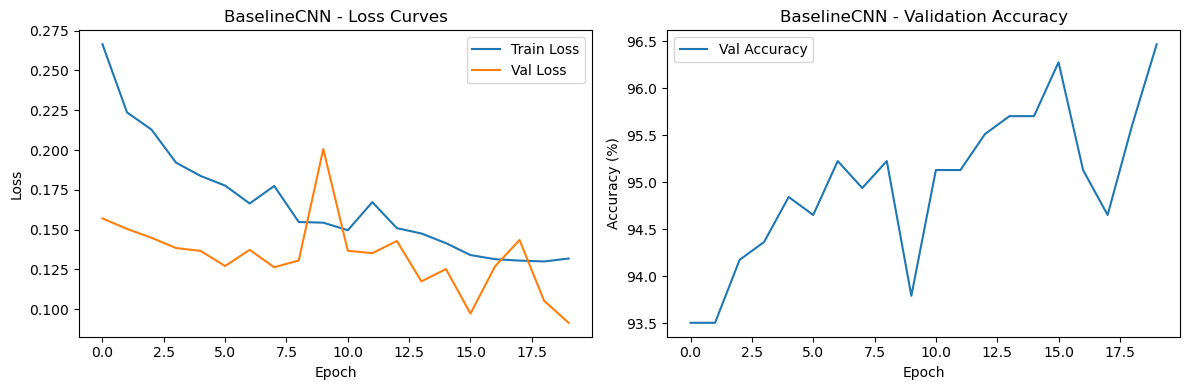

In [69]:
# Baseline
print("Training BaselineCNN...")
optimizer_base = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
baseline_train_losses, baseline_val_losses, baseline_val_accs = train_with_metrics(
    baseline_model, train_loader, val_loader, criterion, optimizer_base, epochs=20
)

# Plot curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_train_losses, label='Train Loss')
plt.plot(baseline_val_losses, label='Val Loss')
plt.title('BaselineCNN - Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_val_accs, label='Val Accuracy')
plt.title('BaselineCNN - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Training CustomCNN...
Epoch [1/20] | Train Loss: 0.4124 | Val Loss: 0.2937 | Val Acc: 84.43%
Epoch [2/20] | Train Loss: 0.3242 | Val Loss: 0.2398 | Val Acc: 89.11%
Epoch [3/20] | Train Loss: 0.2855 | Val Loss: 0.2668 | Val Acc: 88.35%
Epoch [4/20] | Train Loss: 0.2734 | Val Loss: 0.2324 | Val Acc: 89.21%
Epoch [5/20] | Train Loss: 0.2716 | Val Loss: 0.2279 | Val Acc: 89.49%
Epoch [6/20] | Train Loss: 0.2503 | Val Loss: 0.2053 | Val Acc: 89.88%
Epoch [7/20] | Train Loss: 0.2271 | Val Loss: 0.1873 | Val Acc: 91.31%
Epoch [8/20] | Train Loss: 0.2254 | Val Loss: 0.2223 | Val Acc: 89.68%
Epoch [9/20] | Train Loss: 0.2143 | Val Loss: 0.1980 | Val Acc: 91.21%
Epoch [10/20] | Train Loss: 0.2096 | Val Loss: 0.1490 | Val Acc: 94.27%
Epoch [11/20] | Train Loss: 0.1949 | Val Loss: 0.1679 | Val Acc: 94.08%
Epoch [12/20] | Train Loss: 0.2053 | Val Loss: 0.1579 | Val Acc: 92.36%
Epoch [13/20] | Train Loss: 0.1840 | Val Loss: 0.1666 | Val Acc: 92.84%
Epoch [14/20] | Train Loss: 0.1962 | Val Loss: 0.18

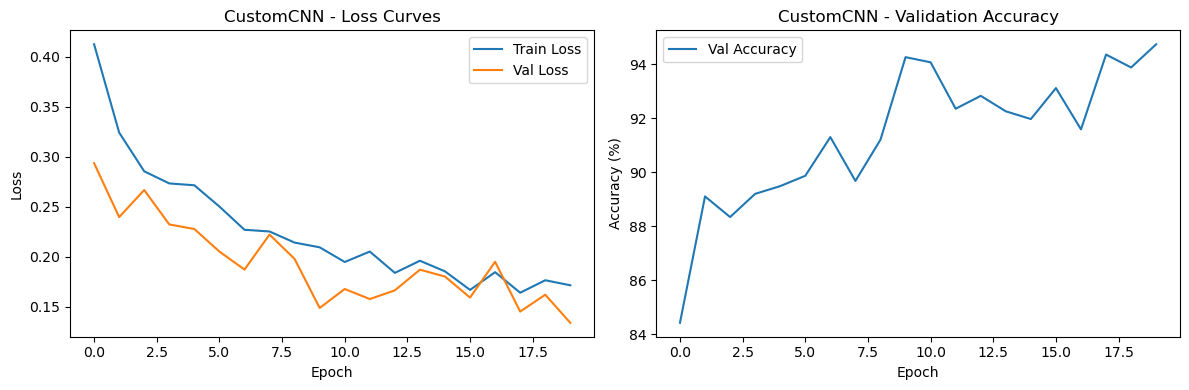

In [70]:
# CustomCNN

print("Training CustomCNN...")
optimizer_custom = torch.optim.Adam(custom_model.parameters(), lr=0.001)
custom_train_losses,custom_val_losses,custom_val_accs = train_with_metrics(custom_model,train_loader,val_loader,criterion,optimizer_custom,epochs=20)

# Plot curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(custom_train_losses, label='Train Loss')
plt.plot(custom_val_losses, label='Val Loss')
plt.title('CustomCNN - Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_val_accs, label='Val Accuracy')
plt.title('CustomCNN - Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

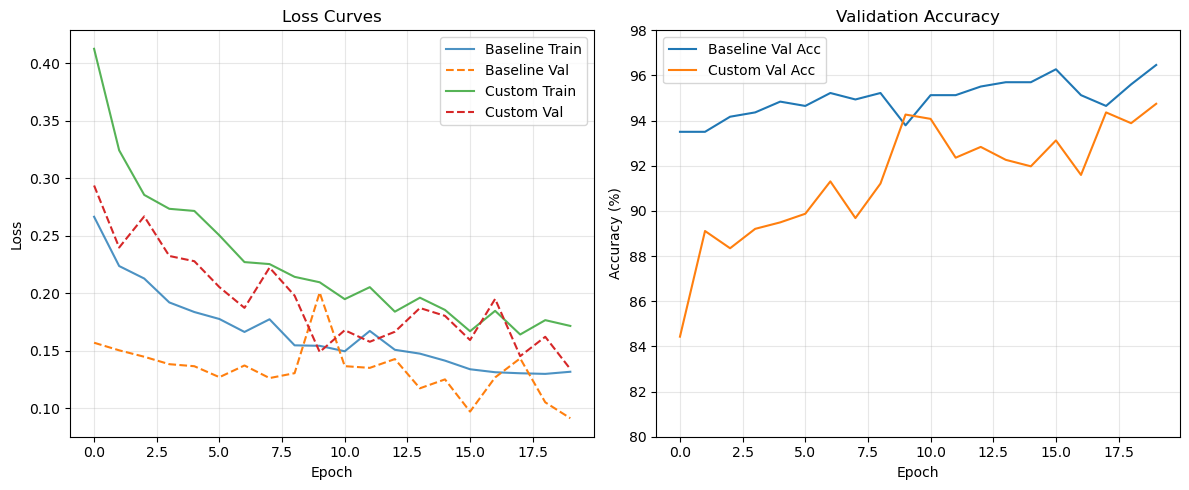

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_train_losses, label='Baseline Train', alpha=0.8)
plt.plot(baseline_val_losses,   label='Baseline Val', linestyle='--')
plt.plot(custom_train_losses,   label='Custom Train', alpha=0.8)
plt.plot(custom_val_losses,     label='Custom Val',   linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(baseline_val_accs, label='Baseline Val Acc')
plt.plot(custom_val_accs,   label='Custom Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(80, 98)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


BaselineCNN - Test Accuracy: 76.60%
              precision    recall  f1-score   support

      NORMAL       0.97      0.39      0.55       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624



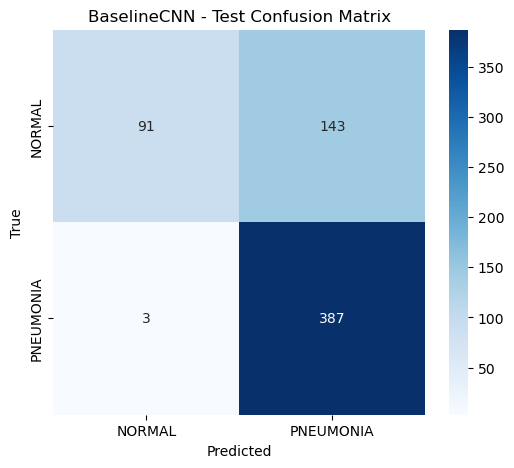


CustomCNN - Test Accuracy: 83.01%
              precision    recall  f1-score   support

      NORMAL       0.91      0.61      0.73       234
   PNEUMONIA       0.80      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



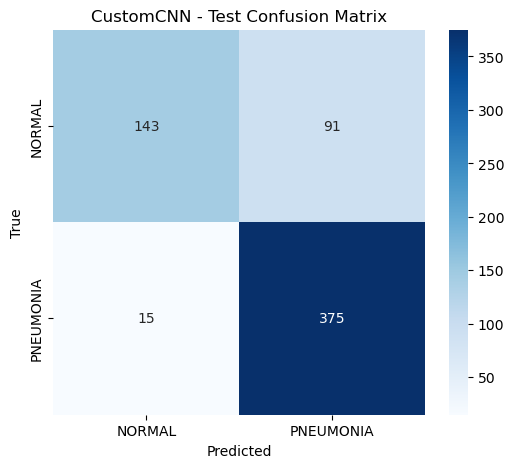

In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, loader, name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    acc = accuracy_score(y_true, y_pred) * 100
    print(f"\n{name} - Test Accuracy: {acc:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f'{name} - Test Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

evaluate_model(baseline_model, test_loader, "BaselineCNN")
evaluate_model(custom_model,   test_loader, "CustomCNN")

Visualizing errors for BaselineCNN...


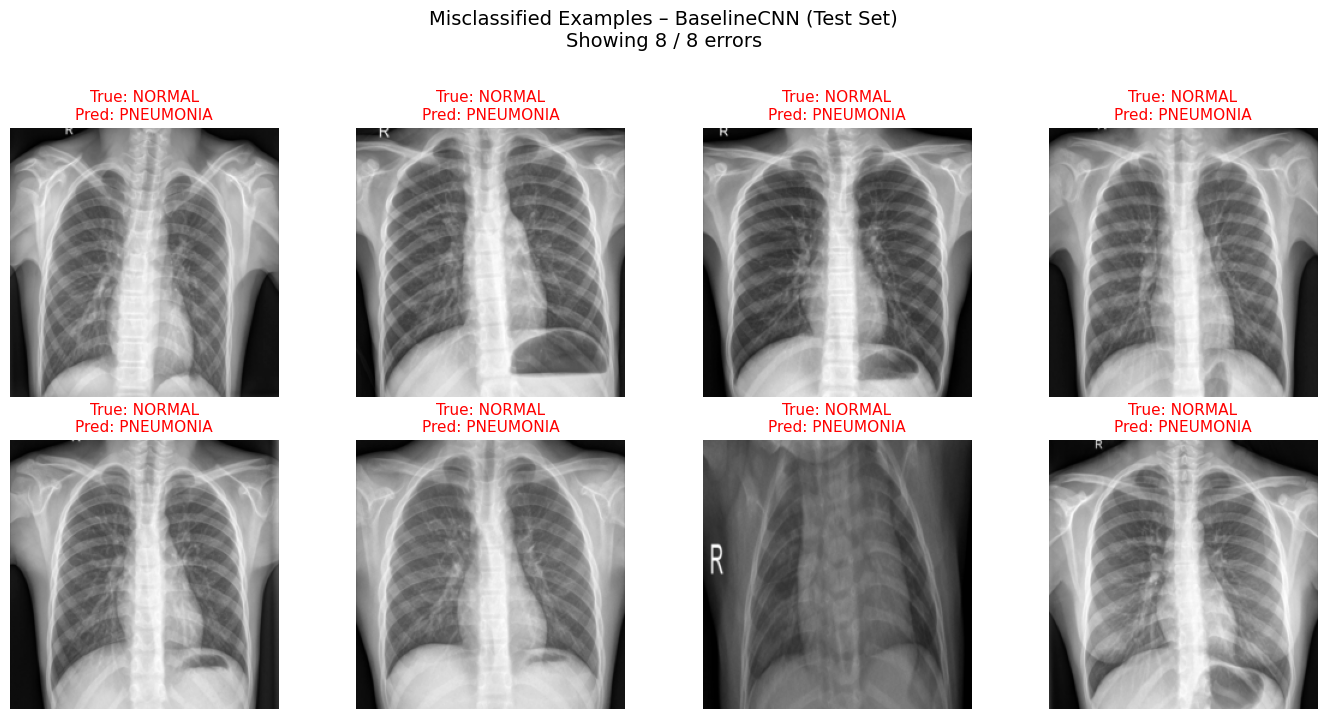


Visualizing errors for CustomCNN...


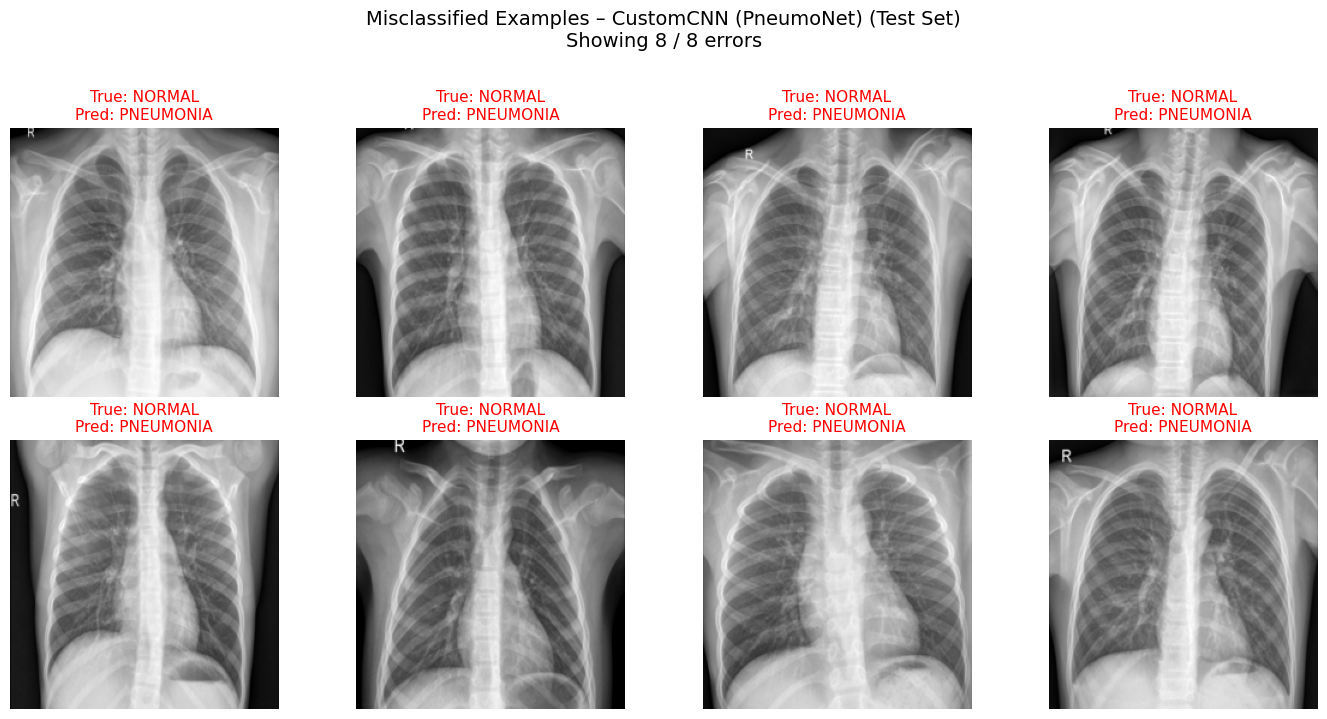

In [ ]:
import random

def show_misclassified_examples(model, loader, model_name, num_samples=8):
    model.eval()
    misclassified = []  

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            wrong_mask = preds != labels
            if wrong_mask.any():
                wrong_images = images[wrong_mask]    
                wrong_labels = labels[wrong_mask].numpy()
                wrong_preds  = preds[wrong_mask].numpy()

                for img, true, pred in zip(wrong_images, wrong_labels, wrong_preds):
                    misclassified.append((img, true, pred))

            if len(misclassified) >= num_samples:
                break

    if not misclassified:
        print(f"No misclassifications found for {model_name}!")
        return

    n_show = min(num_samples, len(misclassified))
    if len(misclassified) > n_show:
        indices = random.sample(range(len(misclassified)), n_show)
        misclassified = [misclassified[i] for i in indices]

    fig, axes = plt.subplots(2, 4, figsize=(14, 7)) if n_show <= 8 else plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    class_names = ['NORMAL', 'PNEUMONIA']

    for i, (img_tensor, true_lbl, pred_lbl) in enumerate(misclassified[:n_show]):
        img = img_tensor.squeeze().numpy()

        img = img * 0.229 + 0.485
        img = np.clip(img, 0, 1)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {class_names[true_lbl]}\nPred: {class_names[pred_lbl]}",
                          color='red' if true_lbl != pred_lbl else 'black',
                          fontsize=11)
        axes[i].axis('off')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Misclassified Examples – {model_name} (Test Set)\n"
                 f"Showing {len(misclassified)} / {n_show} errors", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


print("Visualizing errors for BaselineCNN...")
show_misclassified_examples(baseline_model, test_loader, "BaselineCNN", num_samples=8)

print("\nVisualizing errors for CustomCNN...")
show_misclassified_examples(custom_model, test_loader, "CustomCNN (PneumoNet)", num_samples=8)